<a href="https://colab.research.google.com/github/pritampalit/ML4DQM/blob/master/Skill_of_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Using ROC curve, PR curve and Confusion matrix to evaluate the skill of Classifier
# PR curve is more effective in case of Imbalanced dataset
#Author : Pritam Palit, Shamik Ghosh & Francesco Fiori , 14/06/2020

In [2]:
import pandas as pd
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import json
#df= pd.read_csv('Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv')
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv') # To read CSV in Google Colab
df['histo']=df['histo'].apply(literal_eval)

df.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df.sort_index(inplace=True)
print(df['histo'].shape)
print(df.tail())
print(df.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
(225954,)
                  Unnamed: 0  ...                                              histo
fromrun fromlumi              ...                                                   
306462  95             67823  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        96             67824  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        97             67825  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
        98             67826 

In [3]:
import seaborn as sns
from pylab import rcParams
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(1)
import tensorflow
#from tensorflow import set_random_seed
tensorflow.random.set_seed(2)
#set_random_seed(2)
SEED = 123 #used to help randomly select the data points (For Train-test split)
DATA_SPLIT_PCT = 0.2
DATA_SPLIT_PCT_VALID = 0.1
rcParams['figure.figsize'] = 10, 6

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
#add Golden JSON labels to the DF
import json

def checkLS(run,ls):
    isok=False
    global jsondata

    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok=True
                return isok
        return   isok

#load the golden json file
jsondata={}
#with open('GoldenJSON17.json') as json_file: # While not in Google Colab
with open('/content/drive/My Drive/Colab Notebooks/GoldenJSON17.json') as json_file:
    jsondata = json.load(json_file)

df['labels']=False #initialize to false

for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:
        df['labels'][run][ls]=checkLS(run,ls)

# 'type' is just opposite of labels to take Good as 0 and Bad as 1 automatically for the input of ROC & PR curves
df['type']=df['labels']
df['type']=df['type'].apply(lambda x:0 if x== True else 1)
df[df['type']==0]

Unnamed: 0  fromrun  ...  labels type
fromrun fromlumi                       ...             
297050  12              4535   297050  ...    True    0
        13              4536   297050  ...    True    0
        14             15690   297050  ...    True    0
        15             15691   297050  ...    True    0
        16              4537   297050  ...    True    0
...                      ...      ...  ...     ...  ...
306460  60             62547   306460  ...    True    0
        61             62548   306460  ...    True    0
        62             62549   306460  ...    True    0
        63             62550   306460  ...    True    0
        64             62551   306460  ...    True    0

[202299 rows x 12 columns]

In [0]:
# Split total dataset into Train , Test and Validation (72:20:8)%
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT_VALID, random_state=SEED)

X_train_true = np.stack(df_train['histo'][df_train['labels']==True].values, axis=0)
X_train_false = np.stack(df_train['histo'][df_train['labels']==False].values, axis=0)

X_valid_true = np.stack(df_valid['histo'][df_valid['labels']==True].values, axis=0)
X_valid_false = np.stack(df_valid['histo'][df_valid['labels']==False].values, axis=0)


X_test_true = np.stack(df_test['histo'][df_test['labels']==True].values, axis=0)
X_test_false = np.stack(df_test['histo'][df_test['labels']==False].values, axis=0)

from sklearn.preprocessing import normalize

X_train_true_norm=normalize(X_train_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_train_false_norm=normalize(X_train_false, norm='l1', axis=1)

X_valid_true_norm=normalize(X_valid_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_valid_false_norm=normalize(X_valid_false, norm='l1', axis=1)

X_test_true_norm=normalize(X_test_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test_false_norm=normalize(X_test_false, norm='l1', axis=1)


In [6]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

nb_epoch = 100
batch_size = 500
input_dim = X_train_true_norm.shape[1] #num of predictor variables, 
encoding_dim = 10
hidden_dim = 3
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)  
decoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(encoding_dim, activation="tanh")(decoder)
decoder = Dense(input_dim, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1100      
Total params: 2,183
Trainable params: 2,183
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.compile(metrics=['accuracy'],
                    loss=mseTop10,
                    optimizer='adam')
history = autoencoder.fit(X_train_true_norm, X_train_true_norm,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_valid_true_norm, X_valid_true_norm),
                    verbose=1,
                    ).history

Train on 145591 samples, validate on 16212 samples
Epoch 1/100
145591/145591 [==============================] - 3s 24us/step - loss: 1.5139e-04 - accuracy: 0.1289 - val_loss: 2.2775e-05 - val_accuracy: 0.2808
Epoch 2/100
145591/145591 [==============================] - 2s 11us/step - loss: 1.2692e-05 - accuracy: 0.3649 - val_loss: 5.3096e-06 - val_accuracy: 0.4242
Epoch 3/100
145591/145591 [==============================] - 2s 11us/step - loss: 4.9737e-06 - accuracy: 0.4365 - val_loss: 4.3167e-06 - val_accuracy: 0.4378
Epoch 4/100
145591/145591 [==============================] - 2s 11us/step - loss: 4.4519e-06 - accuracy: 0.4390 - val_loss: 3.9704e-06 - val_accuracy: 0.4373
Epoch 5/100
145591/145591 [==============================] - 2s 11us/step - loss: 4.0221e-06 - accuracy: 0.4347 - val_loss: 3.4173e-06 - val_accuracy: 0.4354
Epoch 6/100
145591/145591 [==============================] - 2s 11us/step - loss: 3.2889e-06 - accuracy: 0.4353 - val_loss: 2.6900e-06 - val_accuracy: 0.4411
E

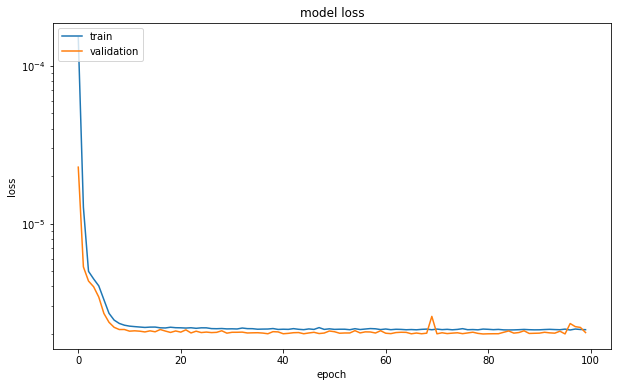

In [8]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

# "Loss"
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale("log")
plt.show()


In [0]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy import sqrt
from numpy import argmax
import seaborn as sns

#Details of Reconstruction error for Test dataset
# df must have two columns : 'histo' & 'type' as described above
# 'true class' of column 'type' will help to classify '1' (Positive) for Anomaly and '0' (Negative) for Good, to draw ROC & P-R curves
def Skill_of_Classifier(df) :
  X_all = np.stack(df['histo'].values, axis=0)
  X_all_norm=normalize(X_all, norm='l1', axis=1)
  x_predictions = autoencoder.predict(X_all_norm)
  mse=K.eval(mseTop10(X_all_norm, x_predictions))
  print(mse)
  error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': df['type']})
  print(error_df.describe())
  
  # Plot ROC curve and calculate g-mean to find the best point of ROC curve
  fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
  roc_auc = auc(fpr, tpr)
  # calculate the g-mean for each threshold
  gmeans = sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = argmax(gmeans)
  print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
  fig = plt.figure(1)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
  plt.xlim([-0.001, 1])
  plt.ylim([0, 1.001])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  
  # Plot PR curve and calculate f-score to find the best point of ROC curve
  precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
  auc_PR = auc(recall, precision)
  # convert to f score
  fscore = (2 * precision * recall) / (precision + recall)
  # locate the index of the largest f1 score
  ix = argmax(fscore)
  print('Best Threshold=%f, F-Score=%.3f' % (th[ix], fscore[ix]))
  plt.figure(2)
  plt.plot(recall, precision, 'b', label='AUC = %0.4f'% auc_PR)
  plt.legend(loc='upper right')
  plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
  plt.title('Recall vs Precision')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  
  # Plot Precision and recall for different threshold values for to get the ideal threshold
  plt.figure(3)
  plt.plot(th, precision[1:], label="Precision",linewidth=5)
  plt.plot(th, recall[1:], label="Recall",linewidth=5)
  plt.legend(loc='right')
  plt.title('Precision and recall for different threshold values')
  plt.xlabel('Threshold')
  plt.ylabel('Precision/Recall')

  # Confusion Matrix to get the Actual Class vs Predicted Class
  threshold = th[ix] # Using threshold of PR curve
  LABELS = ['Good', 'Anomaly']
  y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df.true_class, y_pred)
  plt.figure(4)
  sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
  plt.title("Confusion matrix for Test, th = %f" % (th[ix]))
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  plt.show();


[4.63054508e-06 9.12077569e-07 6.40546345e-07 ... 4.41183952e-06
 1.48729948e-06 3.08437137e-06]
       reconstruction_error    true_class
count          4.519100e+04  45191.000000
mean           3.097992e-05      0.103892
std            1.339971e-04      0.305124
min            1.659883e-07      0.000000
25%            9.543681e-07      0.000000
50%            1.703064e-06      0.000000
75%            2.538308e-06      0.000000
max            3.984009e-03      1.000000
Best Threshold=0.000004, G-Mean=0.757
Best Threshold=0.000014, F-Score=0.709


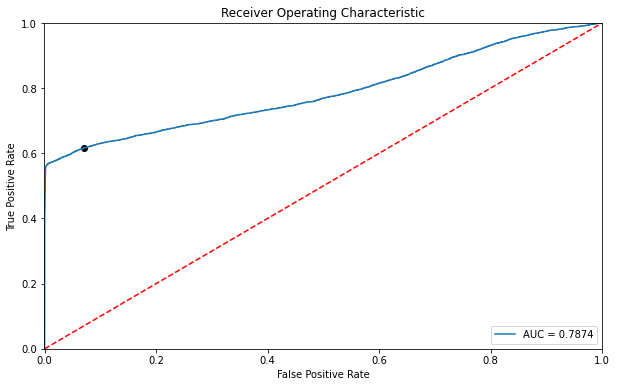

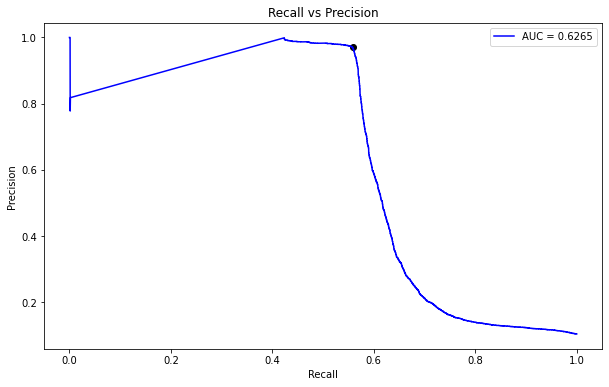

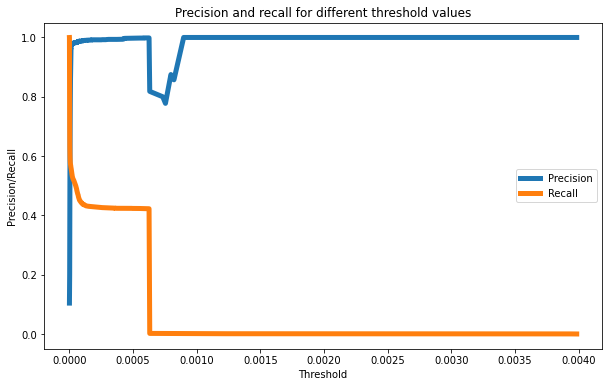

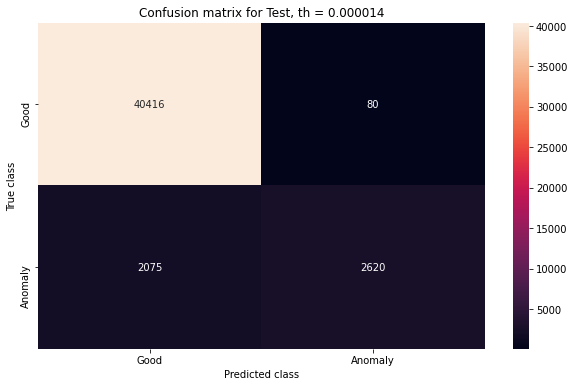

In [12]:
Skill_of_Classifier(df_test)